In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
user_features_df = pd.read_csv("../../data/carousel_bandit/user_features.csv")
playlist_feature_df = pd.read_csv("../../data/carousel_bandit/playlist_features.csv")

In [3]:
print(f"user_features_df shape: {user_features_df.shape}")
print(f"playlist_feature_df shape: {playlist_feature_df.shape}")

user_features_df shape: (974960, 97)
playlist_feature_df shape: (862, 97)


In [4]:
user_features_df.columns

Index(['segment', 'dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5',
       'dim_6', 'dim_7', 'dim_8', 'dim_9', 'dim_10', 'dim_11', 'dim_12',
       'dim_13', 'dim_14', 'dim_15', 'dim_16', 'dim_17', 'dim_18', 'dim_19',
       'dim_20', 'dim_21', 'dim_22', 'dim_23', 'dim_24', 'dim_25', 'dim_26',
       'dim_27', 'dim_28', 'dim_29', 'dim_30', 'dim_31', 'dim_32', 'dim_33',
       'dim_34', 'dim_35', 'dim_36', 'dim_37', 'dim_38', 'dim_39', 'dim_40',
       'dim_41', 'dim_42', 'dim_43', 'dim_44', 'dim_45', 'dim_46', 'dim_47',
       'dim_48', 'dim_49', 'dim_50', 'dim_51', 'dim_52', 'dim_53', 'dim_54',
       'dim_55', 'dim_56', 'dim_57', 'dim_58', 'dim_59', 'dim_60', 'dim_61',
       'dim_62', 'dim_63', 'dim_64', 'dim_65', 'dim_66', 'dim_67', 'dim_68',
       'dim_69', 'dim_70', 'dim_71', 'dim_72', 'dim_73', 'dim_74', 'dim_75',
       'dim_76', 'dim_77', 'dim_78', 'dim_79', 'dim_80', 'dim_81', 'dim_82',
       'dim_83', 'dim_84', 'dim_85', 'dim_86', 'dim_87', 'dim_88', 'dim_89',
       '

In [118]:
n_users = user_features_df.shape[0]
n_playlists = playlist_feature_df.shape[0]
n_recos = 12
l_init = 3
n_users_per_round = 2000
n_rounds = 50

In [6]:
user_segment = np.array(user_features_df["segment"])
user_features = np.concatenate(
    [user_features_df.drop(["segment"], axis=1), np.ones((n_users, 1))], axis=1
)
playlist_features = np.array(playlist_feature_df)

In [8]:
# ContextualEnvironment 는 offline 에서 시뮬레이션을 위한 클래스
# TODO: https://github.com/deezer/carousel_bandits/blob/master/environment.py 참고해서 구현

In [122]:
class ContextualEnvironment:
    def __init__(self, user_features, playlist_features, user_segment, n_recos):
        self.user_features = user_features
        self.playlist_features = playlist_features
        self.user_segment = user_segment
        self.n_recos = n_recos
        self.th_rewards = np.zeros(user_features.shape[0])
        self.th_segment_rewards = np.zeros(user_features.shape[0])
        self.compute_optimal_theoretical_rewards()
        self.compute_segment_optimal_theoretical_rewards()

    # Computes highest expected reward for each user
    def compute_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        step = 100000
        for n_step in range(0, n_users, step):
            users_ids = range(n_step, min(n_step + step, n_users))
            opt_recos = self.compute_optimal_recos(users_ids, self.n_recos)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_rewards[n_step : n_step + step] = opt_rewards

    # Computes list of n recommendations with highest expected reward for each user
    def compute_optimal_recos(self, users_ids, n_recos):
        users_ids_features = np.take(self.user_features, users_ids, axis=0)
        probs = np.dot(users_ids_features, self.playlist_features.T)
        optimal_recos = np.argsort(-probs)[:, :n_recos]
        return optimal_recos

    # Computes highest expected reward for each user
    def compute_theoretical_rewards(self, users_ids, recos):
        users_ids_features = np.take(self.user_features, users_ids, axis=0)
        recos_features = np.take(self.playlist_features, recos, axis=0)
        th_reward = np.zeros(len(users_ids))
        for i in range(len(users_ids)):
            probs = self.sigmoid(
                np.dot(users_ids_features[i], recos_features[i].T)
            )  # |probs| = (n_recos,)
            th_reward[i] = 1 - np.prod(1 - probs)
        return th_reward

    def compute_segment_optimal_recos(self, n_recos):
        n_seg = len(np.unique(self.user_segment))
        seg_recos = np.zeros((n_seg, n_recos), dtype=np.int64)
        for i in range(n_seg):
            users_ids = np.where(self.user_segment == i)[0]
            users_id_features = np.take(self.user_features, users_ids, axis=0)
            probs = self.sigmoid(np.dot(users_id_features, self.playlist_features.T))
            probs_mean = np.mean(
                probs, axis=0
            )  # |probs_mean| = (self.playlist_features.shape[0],)
            seg_recos[i] = np.argsort(-probs_mean)[:n_recos]
        return seg_recos

    def compute_segment_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        seg_opt_recos = self.compute_segment_optimal_recos(self.n_recos)
        step = 100000
        for n_step in range(0, n_users, step):
            users_ids = range(n_step, min(n_step + step, n_users))
            user_seg = np.take(self.user_segment, users_ids)
            opt_recos = np.take(seg_opt_recos, user_seg)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_segment_rewards[n_step : n_step + step] = opt_rewards

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def simulate_batch_users_reward(self, batch_user_ids, batch_recos):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis=0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis=0)
        n_users = len(batch_user_ids)
        n_playlists = len(batch_recos[0])
        probs = np.zeros((n_users, n_playlists), dtype=np.float64)
        for i in range(n_users):
            probs[i] = self.sigmoid(
                np.dot(batch_user_features[i], (batch_playlist_features[i].T))
            )
        rewards = np.zeros((n_users, n_playlists), dtype=np.int64)
        rewards_uncascaded = np.random.binomial(1, probs)
        positive_rewards = set()

        # Then, for each user, positive rewards after the first one are set to 0 (and playlists as "unseen" subsequently) to imitate a cascading browsing behavior
        # (nonetheless, users can be drawn several times in the batch of a same round ; therefore, each user
        # can have several positive rewards - i.e. stream several playlists - in a same round, consistently with
        # the multiple-plays framework from the paper)
        # 유저가 처음 positive 가 발생한 것에 대해서만 reward 를 주고, 그 이후에는 0 으로 설정 하는 과정
        nz = (
            rewards_uncascaded.nonzero()
        )  # nonzero 의 index, 2d 일떄 [0] 이 x, [1] 이 y 좌표
        for i in range(len(nz[0])):
            if nz[0][i] not in positive_rewards:
                rewards[nz[0][i]][nz[1][i]] = 1
                positive_rewards.add(nz[0][i])
        return rewards

In [123]:
cont_env = ContextualEnvironment(
    user_features, playlist_features, user_segment, n_recos
)

In [68]:
class Policy:

    # Returns a list of size n_recos of playlist ids
    def recommend_to_users_batch(self, batch_users, n_recos=12):
        return

    # Updates policies parameters
    def update_policy(self, user_ids, recos, rewards, l_init=3):
        return

In [69]:
# A simple baseline that randomly recommends n_recos playlists to each user.
class RandomPolicy(Policy):
    def __init__(self, n_playlists, cascade_model=True):
        self.cascade_model = cascade_model
        self.n_playlists = n_playlists

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos))
        r = np.arange(self.n_playlists)
        for i in range(n_users):
            np.random.shuffle(r)
            recos[i] = r[:n_recos]
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        return

In [70]:
# Segment-based Epsilon-Greedy strategy: recommends playlists randomly with probability epsilon,
# otherwise recommends the top n_recos with highest mean observed rewards.
class EpsilonGreedySegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, epsilon, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.epsilon = epsilon
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        n_users = len(batch_users)
        user_segment = np.take(self.user_segment, batch_users)
        user_scores = np.take(self.playlist_score, user_segment, axis=0)
        user_random_score = np.random.random(
            user_scores.shape
        )  # |user_random_score| = (n_users, n_playlists)
        user_greedy = np.random.binomial(1, [1 - self.epsilon] * n_users)
        new_scores = user_scores * user_greedy[:, np.newaxis]
        user_choice = np.lexsort((user_random_score, -new_scores))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

In [135]:
# Segment-based Thompson Sampling strategy, with Beta(alpha_zero,beta_zero) priors
class TSSegmentPolicy(Policy):
    def __init__(
        self, user_segment, n_playlists, alpha_zero=1, beta_zero=99, cascade_model=True
    ):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.alpha_zero = alpha_zero
        self.beta_zero = beta_zero
        self.t = 0
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_displays = np.take(self.playlist_display, user_segment, axis=0).astype(
            float
        )
        user_success = np.take(self.playlist_success, user_segment, axis=0)
        user_score = np.random.beta(
            self.alpha_zero + user_success,
            self.beta_zero + user_displays - user_success,
        )
        user_choice = np.argsort(-user_score)[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display += 1
                self.playlist_success[user_segment][p] += r
                self.playlist_display[user_segment][p] += 1
                if self.cascade_model and (
                    (total_stream == 0 and nb_display == l_init) or (r == 1)
                ):
                    break
        return

In [136]:
# 각 round 마다 random 하게 유저를 선택
n_rounds = 20
n_users_per_round = 20000

policies = [
    RandomPolicy(n_playlists),
    EpsilonGreedySegmentPolicy(user_segment, n_playlists, 0.1),
    TSSegmentPolicy(user_segment, n_playlists),
]

n_policies = len(policies)
policies_name = ["Random", "EpsilonGreedySegment"]
overall_rewards = np.zeros((n_policies, n_rounds))
overall_optimal_reward = np.zeros(n_rounds)

for i in tqdm(range(n_rounds)):
    user_ids = np.random.choice(range(n_users), n_users_per_round)
    overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
    # 각 policy 별로 reward 계산
    for j, policy in tqdm(enumerate(policies)):
        recos = policy.recommend_to_users_batch(user_ids, n_recos, l_init)
        rewards = cont_env.simulate_batch_users_reward(user_ids, recos.astype(np.int64))
        policy.update_policy(user_ids, recos, rewards, l_init)
        overall_rewards[j, i] = rewards.sum()
    # print(f"[ Round {i} cumulative regret ]")
    # for i in range(n_policies):
    #     print(f"{policies_name[i]}: {round(np.sum(overall_optimal_reward - overall_rewards[i]))}")
    # print("")

3it [00:04,  1.34s/it][00:00<?, ?it/s]
3it [00:04,  1.36s/it][00:04<01:17,  4.09s/it]
3it [00:03,  1.33s/it][00:08<01:13,  4.11s/it]
3it [00:03,  1.33s/it][00:12<01:09,  4.08s/it]
3it [00:03,  1.30s/it][00:16<01:04,  4.06s/it]
3it [00:03,  1.30s/it][00:20<01:00,  4.02s/it]
3it [00:03,  1.29s/it][00:24<00:55,  3.99s/it]
3it [00:03,  1.31s/it][00:28<00:51,  3.96s/it]
3it [00:03,  1.29s/it][00:32<00:47,  3.97s/it]
3it [00:03,  1.29s/it][00:35<00:43,  3.95s/it]
3it [00:03,  1.29s/it] [00:39<00:39,  3.94s/it]
3it [00:03,  1.28s/it] [00:43<00:35,  3.92s/it]
3it [00:03,  1.29s/it] [00:47<00:31,  3.92s/it]
3it [00:03,  1.30s/it] [00:51<00:27,  3.91s/it]
3it [00:03,  1.29s/it] [00:55<00:23,  3.92s/it]
3it [00:03,  1.29s/it] [00:59<00:19,  3.91s/it]
3it [00:03,  1.29s/it] [01:03<00:15,  3.92s/it]
3it [00:03,  1.29s/it] [01:07<00:11,  3.92s/it]
3it [00:03,  1.29s/it] [01:11<00:07,  3.92s/it]
3it [00:03,  1.31s/it] [01:15<00:03,  3.92s/it]
100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


In [138]:
n_policies = len(policies)
policies_name = ["Random", "EpsilonGreedySegment", "TSSegment"]
cumulative_regrets = {
    policies_name[j]: list(np.cumsum(overall_optimal_reward - overall_rewards[j]))
    for j in range(n_policies)
}

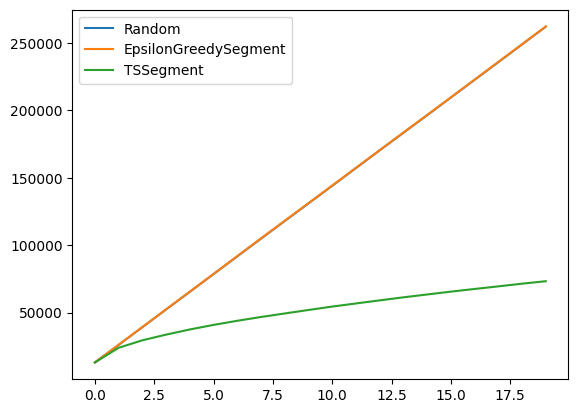

In [140]:
for policy, cum_reg in cumulative_regrets.items():
    plt.plot(cum_reg, label=policy)
plt.legend(policies_name)